Download the Intel Image Classification dataset and unzip it: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

You will observe that the data is already partitioned into training and test set, and that the files are arranged by folders.

## 1.1 Exploration

Write code that does the following tasks:

- Assign the list of available classes to a variable with name CLASS_NAMES. For each class name, display one image and print the dimensions of the corresponding numpy array.

- Determine the number of images in the training and test sets for each class name. Are there any significant differences between the proportions of images in the training and test sets?




In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:

# prompt: I want to open this zip file '/content/drive/MyDrive/intel_image.zip'

!unzip '/content/drive/MyDrive/intel_image.zip'



unzip:  cannot find or open /content/drive/MyDrive/intel_image.zip, /content/drive/MyDrive/intel_image.zip.zip or /content/drive/MyDrive/intel_image.zip.ZIP.


In [3]:
# Importing libraries:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import callbacks
!pip install keras_tuner
import keras_tuner as kt

# Functions and variables defined:
# This function produces plots to comapre them (we have been using this since assessment 1.)
def training_plot(metrics, history):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, len(metrics), figsize=(15, 5))

    if len(metrics) == 1:
        ax = [ax]

    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], label=metric)
        ax[idx].plot(history.history['val_' + metric], ls='dashed', label='val_' + metric)
        ax[idx].set_title(metric.capitalize())
        ax[idx].set_xlabel("Epochs")
        ax[idx].legend()

    plt.show()

# Transformation formula that transforms image cell information but not the label corresconding to the image!
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [4]:
# After observing the dataset, we can see all files have below classes:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
CLASS_NAMES

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
# We put labels on the classes so that we can refer it to it later.
class_names_and_label = {CLASS_NAMES:i for i, CLASS_NAMES in enumerate(CLASS_NAMES)}
class_names_and_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [6]:
# We have 6 classes
num_classes = len(CLASS_NAMES)
num_classes

6

In [7]:
# We will load the data first!!!!

# datasets = ["dataset/seg_train/seg_train", "dataset/seg_test/seg_test"]
output = []

In [11]:
# I used these paths in google colab to retrieve data as I wanted access to GPU.
# path_train = "/content/drive/MyDrive/dataset/seg_train/seg_train"
# path_test = "/content/drive/MyDrive/dataset/seg_test/seg_test"

#As I am using local environment on my laptop, I have access to dataset with paths below:
path_train = "Assessment_2/dataset/seg_train/seg_train"
path_test = "Assessment_2/dataset/seg_test/seg_test"

# Checking if the path is read correctly. I can see there is .DS_Store this caused an error so we try to skip reading that .
print(os.listdir(path_train))
print(os.listdir(path_test))

['forest', 'buildings', '.DS_Store', 'glacier', 'street', 'mountain', 'sea']
['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [12]:
# prompt: I need to retrieve all images using os and listdir

for class_name in CLASS_NAMES:
  cur_path = path_train + "/" + class_name
  for image in os.listdir(cur_path):
    if image != '.DS_Store':
      output.append([path_train + "/" + class_name + "/" + image, class_name])

# Do the same for test set
for class_name in CLASS_NAMES:
  cur_path = path_test + "/" + class_name
  for image in os.listdir(cur_path):
    if image != '.DS_Store':
      output.append([path_test + "/" + class_name + "/" + image, class_name])


In [13]:
# prompt: now save the details in a list training_images = []
# training_labels = []

training_images = []
training_labels = []
for i in output:
  training_images.append(i[0])
  training_labels.append(i[1])


In [27]:
training_images = []
training_labels = []

for folder in os.listdir(path_train):
    if not folder.startswith('.'):
        label = class_names_and_label[folder]

        folder_path = os.path.join(path_train, folder)
        for file in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, file)

            # Checking if it's a file because jupyter notebook automatically creates checkpoints and that was causing an error.
            if os.path.isfile(img_path):
                image = plt.imread(img_path)

                training_images.append(image)
                training_labels.append(label)

print("Training Dataset Downloaded")

test_images = []
test_labels = []

for folder in os.listdir(path_test):
    if not folder.startswith('.'):
        label = class_names_and_label[folder]

        folder_path = os.path.join(path_test, folder)
        for file in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, file)

            # Checking if it's a file because jupyter notebook automatically creates checkpoints and that was causing an error.
            if os.path.isfile(img_path):
                image = plt.imread(img_path)

                test_images.append(image)
                test_labels.append(label)

print("Testing Dataset Downloaded")

100%|██████████| 2274/2274 [00:01<00:00, 1372.91it/s]


Training Dataset Downloaded


100%|██████████| 510/510 [00:00<00:00, 1462.58it/s]

Testing Dataset Downloaded


14034
14034
1
(150, 150, 3)


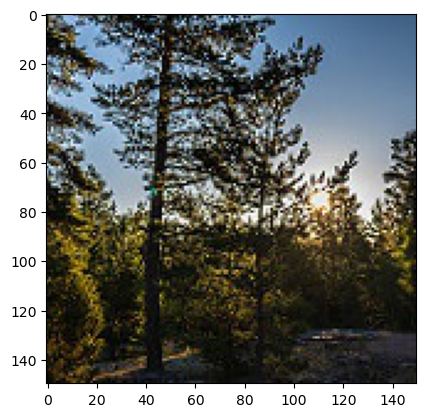

In [28]:
# Testing to see if the reading was successful.
print(len(training_images))
print(len(training_labels))

plt.imshow(training_images[0])
print(training_labels[0])
print(training_images[0].shape)

# returned label 1 is forest as defined in previous cell.
#'forest': 1

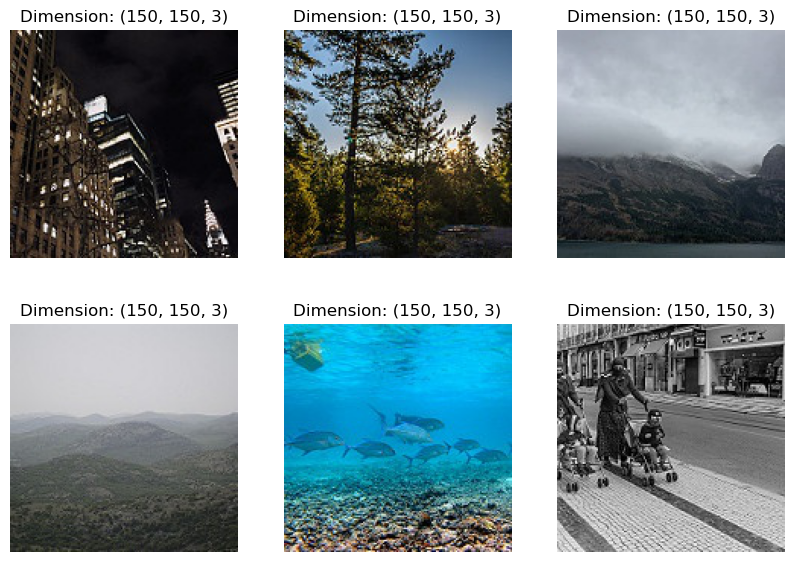

In [29]:
fig = plt.figure(figsize=(10, 7))

# Setting values for rows and columns
rows = 2
columns = 3

dimensions = []

for i in range(6):
    index = training_labels.index(i)  # retrieving the index of the image that matches to the label
    fig.add_subplot(rows, columns, i + 1)  # Add a subplot at the right position
    plt.imshow(training_images[index])  # Display the image matching the index
    plt.title(f"Dimension: {training_images[index].shape}") # Displaying the dimention of the array for each image retrieved in the loop.
    plt.axis('off')

plt.show()

1


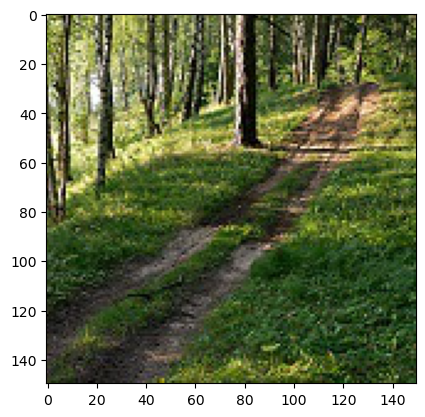

In [30]:
# Seems like the loading dataset was successful!!!
plt.imshow(test_images[0])
print(test_labels[0])

In [31]:
for i in range(0,6):
    print(training_labels.count(i))

2191
2271
2404
2512
2274
2382


In [32]:
for i in range(0,6):
    print(test_labels.count(i))

437
474
553
525
510
501


In [33]:
for i in range(0,6):
    print(i, round(test_labels.count(i)/len(test_labels),4)*100, '%')

0 14.57 %
1 15.8 %
2 18.43 %
3 17.5 %
4 17.0 %
5 16.7 %


In [34]:
# Based on the output above, below output seems correct.
a, training_image_nums = np.unique(training_labels, return_counts=True)
a, test_image_nums = np.unique(test_labels, return_counts=True)

counts = pd.DataFrame({'training dataset': training_image_nums,
                    'test dataset': test_image_nums},
             index=CLASS_NAMES)

counts

,training dataset,test dataset
buildings,2191,437
forest,2271,474
glacier,2404,553
mountain,2512,525
sea,2274,510
street,2382,501


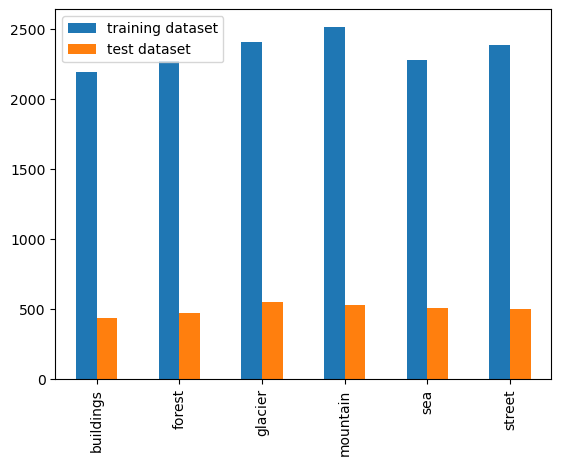

In [35]:
# We can see that all classes have relatively similar amount of images for both training dataset and test dataset.
counts.plot.bar()
plt.show()

Text(0.5, 1.0, 'Training Image Proportion')

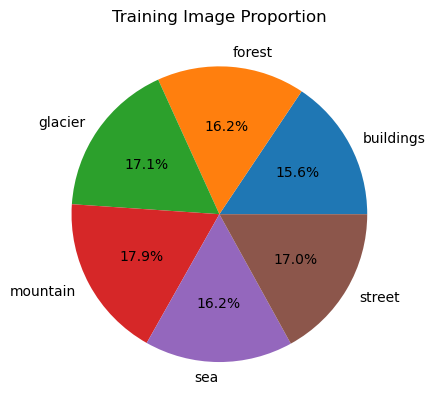

In [36]:
# We look at this closely in percentage. (Training dataset first, then test dataset)
# Of those categories, we can see that buildings class has the least images, and mountain class has the biggest number of images.
fig, ax = plt.subplots()
ax.pie(counts['training dataset'], labels=CLASS_NAMES, autopct='%1.1f%%')
ax.set_title("Training Image Proportion")

Text(0.5, 1.0, 'Test Image Proportion')

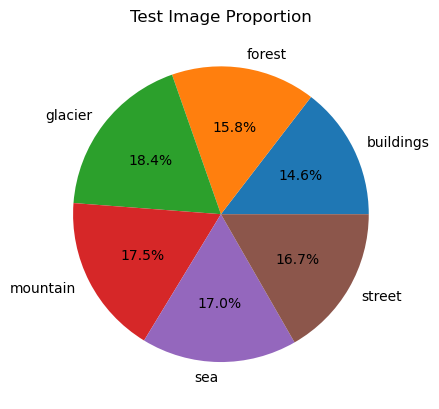

In [37]:
# Test dataset
# In here, we can see that buildings class is still the lowest, however the glacier class has the most images.
fig, ax = plt.subplots()
ax.pie(counts['test dataset'], labels=CLASS_NAMES, autopct='%1.1f%%')
ax.set_title("Test Image Proportion")

***COMMENT:***

Overall, the proportion does not really change for both datasets. It is clear that the all classes do not have the same number of images, however it is approximately close to balanced data.

## 1.2 Preparation

Use TensorFlow's image_dataset_from_directory to generate datasets for training, validation, and test. Make sure that you set the following options:

- Image size: 150 x 150 and 3 channels
- Colour mode = RGB
- Shuffle = True
- Seed = 1234
- Labels = inferred
- Class names = CLASS_NAMES
- Label mode = int or categorical (your choice)
- Batch size = 32
- The other options can be left to their defaults.

To generate the training and validation set, use seg_train and specify a validation split of 0.2. (hint: use the options validation_split and subset.
To generate the test set, use seg_test.
Make sure that the image data are normalised between the values 0 and 1 (this link explains how to do this when using image_dataset_from_directory: https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3)

In [32]:
# Testing to see if this works with a relatively small dataset (test dataset)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_test/seg_test',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32
)

test_dataset = test_dataset.map(process)

Found 3000 files belonging to 6 classes.


In [ ]:
# Checking to see if the transformation was successful.
#
list(test_dataset)[0]

(<tf.Tensor: shape=(32, 150, 150, 3), dtype=float32, numpy=
 array([[[[0.7019608 , 0.84313726, 1.        ],
          [0.7019608 , 0.84705883, 1.        ],
          [0.6784314 , 0.83137256, 0.9843137 ],
          ...,
          [0.05882353, 0.25490198, 0.5411765 ],
          [0.01960784, 0.20784314, 0.49803922],
          [0.02352941, 0.21176471, 0.5019608 ]],
 
         [[0.6745098 , 0.80784315, 0.9843137 ],
          [0.7058824 , 0.8509804 , 1.        ],
          [0.6745098 , 0.827451  , 0.98039216],
          ...,
          [0.01568628, 0.20392157, 0.49411765],
          [0.        , 0.18431373, 0.46666667],
          [0.        , 0.1764706 , 0.45882353]],
 
         [[0.7137255 , 0.84705883, 0.9843137 ],
          [0.7294118 , 0.87058824, 1.        ],
          [0.7058824 , 0.85882354, 1.        ],
          ...,
          [0.01960784, 0.19215687, 0.47843137],
          [0.        , 0.17254902, 0.4509804 ],
          [0.38039216, 0.5529412 , 0.83137256]],
 
         ...,
 
      

In [ ]:
# Generating the training and test datasets
# as we defined the directory path in previous cell, we use that here.
# Useful link found (https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),           # Image size as per request
    color_mode='rgb',                # Colour mode as per request
    shuffle=True,                    # Shuffle the dataset as per request
    seed=1234,                       # Seed for reproducibility as per request
    labels='inferred',               # Automatically infer the class labels as per request
    class_names=CLASS_NAMES,         # Class names as per request
    label_mode='int',                # Choose 'int' or 'categorical' as per request
    batch_size=32,                   # Batch size as per request
    validation_split=0.2,            # Split for validation
    subset='training'                # Specify subset as 'training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='validation'              # Specify subset as 'validation'
)

# Transforming the datasets
train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


**The split and transformation were successful.**
- 20% of the data with seed=1234 shuffle is now in validation_dataset
- 80% of the data with the same shuffle is now found in train_dataset

# Task 2 - A Simple Classifier


## 2.1 First classifier
Create a simple classifier that has the following layers:

**A Flatten layer.**
The output layer with the correct size and activation function for this classification task.
Then, train the model with the training data. Use 20% of the training data to determine when to stop training. Finally, test the trained model on the test data and report the accuracy.

In [13]:
# Reading the datasets again at all times before training a model to mitigate the risk of training on a data that is already used.

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_test/seg_test',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32
)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)
test_dataset = test_dataset.map(process)


# Define the number of classes (should match the length of CLASS_NAMES)
num_classes = len(CLASS_NAMES)

# Create a simple model
model = models.Sequential([
    layers.Flatten(input_shape=(150, 150, 3)),  # Flatten the input image (Simple flatten layer)
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation (the output number is same as the number of classes we have)
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Using 'categorical_crossentropy' as I am using label_mode='int' and that's basically one-hot encoded.
              metrics=['accuracy'])


Found 3000 files belonging to 6 classes.
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Train the model
earlystopping = callbacks.EarlyStopping(monitor="val_loss", #Based on the val_loss we can determine when to stop early
                                        mode="min",
                                        patience=7,
                                        restore_best_weights=True)

history_flatten = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,  # Setting epoch number to 30 to see when the training stops.
    callbacks=[earlystopping] # This callbacks setting helps us not to do too many epochs. Stopping training early if val_loss doesn't improve
)


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3288 - loss: 8.4296 - val_accuracy: 0.2979 - val_loss: 6.4185
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4307 - loss: 3.7942 - val_accuracy: 0.4344 - val_loss: 4.1223
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4306 - loss: 4.1689 - val_accuracy: 0.2944 - val_loss: 5.9218
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4762 - loss: 3.2819 - val_accuracy: 0.4412 - val_loss: 3.0486
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5064 - loss: 2.7062 - val_accuracy: 0.3860 - val_loss: 3.3805
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5154 - loss: 2.6732 - val_accuracy: 0.4505 - val_loss: 3.2314
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4921 - loss: 3.1914 - val_accuracy: 0.3902 - val_loss: 4.0125
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5482 - loss: 2.5972 - val_accuracy: 0.

In [44]:
# Same as in the lecture, we are going to compare Loss and Accuracy with the ones from validation set.
training_plot(['loss', 'accuracy'], history_flatten)

NameError: name 'history_flatten' is not defined

In [16]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4382 - loss: 3.1150
Test accuracy: 43.93%


### Result of Simple Classifier

- Test accuracy is shown as above.
- Model with just a Flatten layer did not perform very well.
- The deviation between accuracy and val-accuracy seems to get bigger and bigger at each epoch.
- val-accuracy seems to be lower than test accuracy throughout the epochs.
- This may suggest that there could be strong overfitting with this model.

## 2.2 A more complex classifier
Try a more complex architecture that has 1 or more hidden layers with dropout. For this more complex architecture, use keras-tuner and run it with a reasonable choice of possible parameters. You may try among the following:

Number of hidden layers
Sizes of hidden layers
Dropout rate
Learning rate

In [31]:
# Reading the datasets again at all times before training a model to mitigate the risk of training on a data that is already used.

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_test/seg_test',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32
)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)
test_dataset = test_dataset.map(process)

Found 3000 files belonging to 6 classes.
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


NameError: name 'process' is not defined

In [18]:
def build_model(hp):
    model = models.Sequential()

    # Input layer
    model.add(layers.Flatten(input_shape=(150, 150, 3)))

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):  # We are picking between 1 and 5 hidden layers
        # Experimenting how many neurons in the hidden layer is good
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), #max_value is 512
                               activation='relu'))
        # for each layer, we are also checking if drop-out is necessary and how much of drop-rate is needed
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [19]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='complicated2',
    project_name='tuning'
)

# Display a summary of the search space
tuner.search_space_summary()


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [20]:
# Perform the hyperparameter search
tuner.search(train_dataset,
             validation_data=validation_dataset,
             epochs=5,
             callbacks=[earlystopping]) # using same patience as the simple model so it is fair

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Display a summary of the best model
best_model.summary()


Trial 8 Complete [00h 00m 23s]
val_accuracy: 0.5509622097015381

Best val_accuracy So Far: 0.5509622097015381
Total elapsed time: 00h 03m 11s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 352)                 │      23,760,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 192)                 │          67,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,829,286 (90.90 MB)

 Trainable params: 23,829,286 (90.90 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the best model
history_complicated = best_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3361 - loss: 2.1681 - val_accuracy: 0.5068 - val_loss: 1.3350
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4706 - loss: 1.3631 - val_accuracy: 0.5292 - val_loss: 1.2169
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5133 - loss: 1.2809 - val_accuracy: 0.5364 - val_loss: 1.2365
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5258 - loss: 1.2262 - val_accuracy: 0.5353 - val_loss: 1.1886
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5432 - loss: 1.1835 - val_accuracy: 0.5449 - val_loss: 1.1758
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5464 - loss: 1.1677 - val_accuracy: 0.5196 - val_loss: 1.2313
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5593 - loss: 1.1431 - val_accuracy: 0.5624 - val_loss: 1.1487
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5886 - loss: 1.0874 - val_accuracy: 0

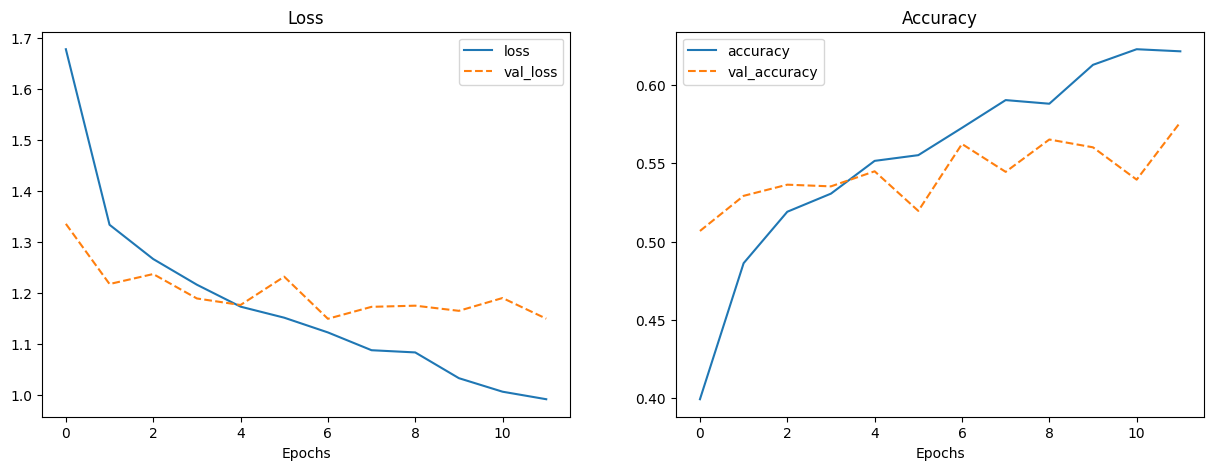

In [22]:
training_plot(['loss', 'accuracy'], history_complicated)

### Result of Complicated Model

- Test accuracy is shown as above and there was a slight improvement compared to the simple Flatten model.
- Validation accuracy starts lowering after epoch 6.
  - Might be the sign of overfitting after epoch 6, so the tuner search with epoch 6 is valid.
- Validation loss seems not to improve after around epoch 6.
- Both suggesting that there are overfitting after epoch 6.

## 2.3 Error analysis
Evaluate your best-performing system from task 2.2 against the system of task 2.1. In separate text cells of your Jupyter notebook, answer the following questions and justify the answer.

- Which system had a better accuracy on the test data?
- Which system had a lower degree of overfitting?

***FINDINGS***

- In terms of accuracy, after tuning the hyperparameters for the complicated model, the model has better accuracy classifying the images.
- Simple model showed a sign of higher degree of overfitting.
- Complicated model has less degree of overfitting thanks to the dropout layers.

## Task 3 - A much more complex model


## Task 3.1 Using ConvNets

- Implement a model that uses a sequence of **at least two ConvD, each one followed with MaxPooling2D.**
- Use reasonable numbers for the hyperparameters **(number of filters, kernel size, pool size, activation, etc)**
- justify your choice.

Feel free to use the material from the lectures, and research the internet and / or generative AI to help you find a reasonable choice of hyperparameters.

**For this task, do not use pre-trained models.**

In [33]:
# Reading the datasets again at all times before training a model to mitigate the risk of training on a data that is already used.

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_test/seg_test',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32
)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './seg_train/seg_train',
    image_size=(150, 150),
    color_mode='rgb',
    shuffle=True,
    seed=1234,
    labels='inferred',
    class_names=CLASS_NAMES,
    label_mode='int',
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)
test_dataset = test_dataset.map(process)

Found 3000 files belonging to 6 classes.
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [24]:
# As we do not want to miss much information from MaxPooling, we use 2 x 2 as its parameter.
# This model is to just explore the performance before tuning, we will work on hyperparameter tuning to achieve higher accuracy after this.

model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3))),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(32, (3, 3), activation = 'relu')),
model.add(MaxPooling2D(2,2)),
model.add(Flatten()),
model.add(Dense(128, activation = 'relu')),
model.add(Dropout(rate=0.2)),
model.add(Dense(256, activation = 'relu')),
model.add(Dropout(rate=0.3)),
model.add(Dense(6, activation = 'softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,353,254 (20.42 MB)

 Trainable params: 5,353,254 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history_ex_complicated = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,  # Setting epoch number to 15 to see when the training stops.
    callbacks=[earlystopping] # This callbacks setting helps us not to do too many epochs. Stopping training early if val_loss doesn't improve
)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.4816 - loss: 1.2857 - val_accuracy: 0.7138 - val_loss: 0.7930
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7178 - loss: 0.7541 - val_accuracy: 0.7637 - val_loss: 0.6571
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7957 - loss: 0.5697 - val_accuracy: 0.7673 - val_loss: 0.6791
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8618 - loss: 0.3908 - val_accuracy: 0.7662 - val_loss: 0.7706
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9110 - loss: 0.2666 - val_accuracy: 0.7545 - val_loss: 0.9198
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9362 - loss: 0.1991 - val_accuracy: 0.7687 - val_loss: 0.8617
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9513 - loss: 0.1436 - val_accuracy: 0.7520 - val_loss: 1.0350
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9607 - loss: 0.1230 - val_acc

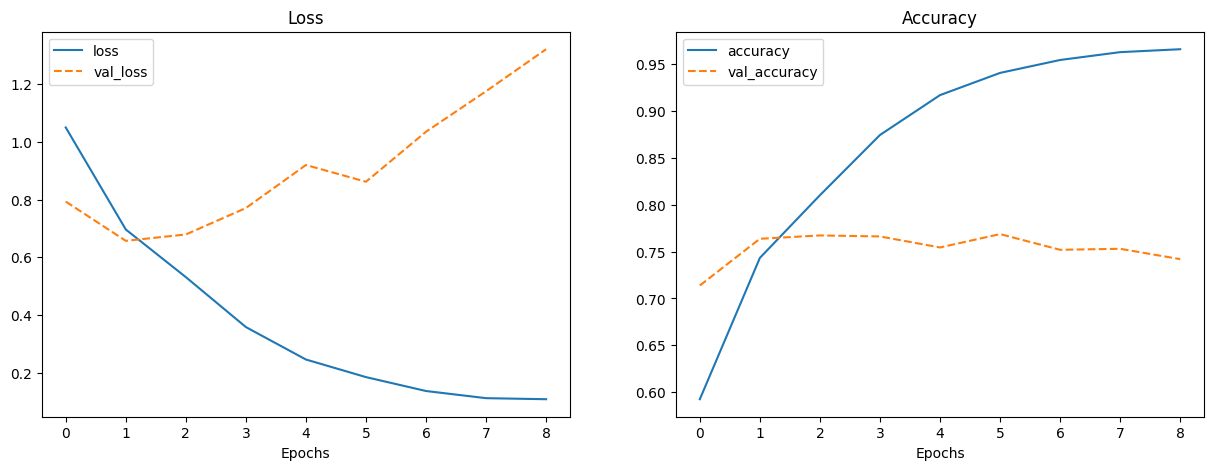

In [27]:
training_plot(['loss', 'accuracy'], history_ex_complicated)

Above plots suggest that the training should stop at epoch 2,3 for this model. We are going to use this as a baseline (to get some idea on what we are working on.)

Links I found useful:
- https://www.kaggle.com/code/gopimali/intel-image-classification-96-accur
- https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://stackoverflow.com/questions/71255862/why-do-we-use-maxpooling-2x2-can-we-use-any-other-size-like-3x3-or-5x5-and-how#:~:text=Obviously%20
- https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

In [28]:
def build_model1(hp):
    model = models.Sequential()

    # Input layer
    model.add(Conv2D(
      hp.Int("conv_1", min_value=32, max_value=128, step=32),
      (3, 3), padding="same", activation='relu', input_shape=(150, 150, 3))),
    model.add(MaxPooling2D(2,2)),
    model.add(Conv2D(
      hp.Int("conv_2", min_value=32, max_value=128, step=32),
      (3, 3), padding="same", activation='relu')),
    model.add(MaxPooling2D(2,2)),
    model.add(layers.Flatten())

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):  # We are picking between 1 and 3 hidden layers
        # Experimenting how many neurons in the hidden layer is good
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                               activation='relu'))
        # for each layer, we are also checking if drop-out is necessary and how much of drop-rate is needed
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [29]:
tuner1 = kt.RandomSearch(
    build_model1,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='ex_comp_tuned1',
    project_name='tuning'
)

# Display a summary of the search space
tuner1.search_space_summary()

Search space summary
Default search space size: 6
conv_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [30]:
# Tuned Model - Parameters are chosen with the RandomSearch method.

tuner1.search(train_dataset,
             validation_data=validation_dataset,
             epochs=3, #we go for epoch 3.
             callbacks=[earlystopping])

# Get the best hyperparameters
best_hps = tuner1.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_1 = tuner1.hypermodel.build(best_hps)

# Display a summary of the best model
best_model_1.summary()


Trial 8 Complete [00h 00m 40s]
val_accuracy: 0.1803278625011444

Best val_accuracy So Far: 0.7794013023376465
Total elapsed time: 00h 08m 34s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 96)          │         110,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 37, 37, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131424)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 416)                 │      54,672,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,816,038 (209.11 MB)

 Trainable params: 54,816,038 (209.11 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the best model
history_ex_complicated = best_model_1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model_1.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.4215 - loss: 1.4779 - val_accuracy: 0.6176 - val_loss: 1.0333
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.6530 - loss: 0.9098 - val_accuracy: 0.7056 - val_loss: 0.7847
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.7635 - loss: 0.6643 - val_accuracy: 0.7484 - val_loss: 0.7036
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.8283 - loss: 0.4926 - val_accuracy: 0.7594 - val_loss: 0.6859
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.8782 - loss: 0.3541 - val_accuracy: 0.7627 - val_loss: 0.8056
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9245 - loss: 0.2178 - val_accuracy: 0.7698 - val_loss: 0.9274
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9507 - loss: 0.1598 - val_accuracy: 0.7577 - val_loss: 0.9935
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.9655 - loss: 0.1098 - 

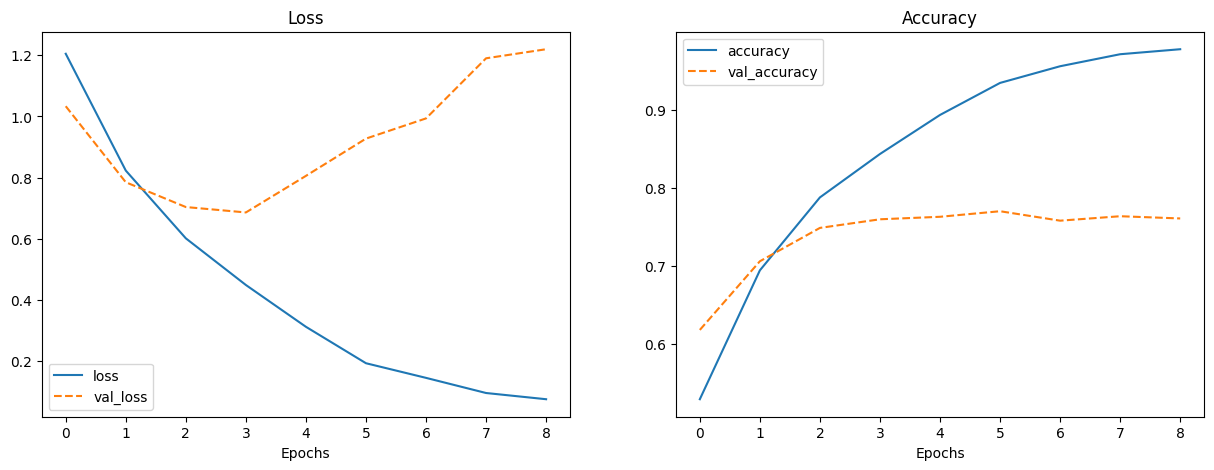

In [32]:
training_plot(['loss', 'accuracy'], history_ex_complicated)

### Result of CNN Model:

- When it comes to accuracy, this model surely has the highest accuracy so far.
- Obvious sign of overfitting
- Epoch 2 is the right epoch.
  - After that, there is a huge gap for both metrics 'loss' and 'accuracy'

## Task 3.2 Using pre-trained models
Use MobileNet, pre-trained on imagenet as discussed in the lectures. Add the correct classification layer, and train it with your data. Make sure that you freeze MobileNet's weights during training.

In [46]:
#See https://www.kaggle.com/code/socathie/pre-trained-mobilenetv2 for reference.

# Download the pre-trained MobileNet model
pre = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model's layers
pre.trainable = False

# Adding classification layer on top of the pre-trained model
model = models.Sequential([
  pre,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

<ipython-input-46-ac48c7dae0f8>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre = tf.keras.applications.MobileNetV2(


In [47]:
# As we can all see that the pre_trained model has more complicated structure.
pre.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [48]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_mobilenet = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.7585 - loss: 0.6400 - val_accuracy: 0.8931 - val_loss: 0.3146
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9033 - loss: 0.2695 - val_accuracy: 0.9013 - val_loss: 0.2924
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9113 - loss: 0.2387 - val_accuracy: 0.9027 - val_loss: 0.2947
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9219 - loss: 0.2115 - val_accuracy: 0.8974 - val_loss: 0.3110
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9297 - loss: 0.1967 - val_accuracy: 0.8995 - val_loss: 0.2926


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8976 - loss: 0.2766
Test accuracy: 89.93%


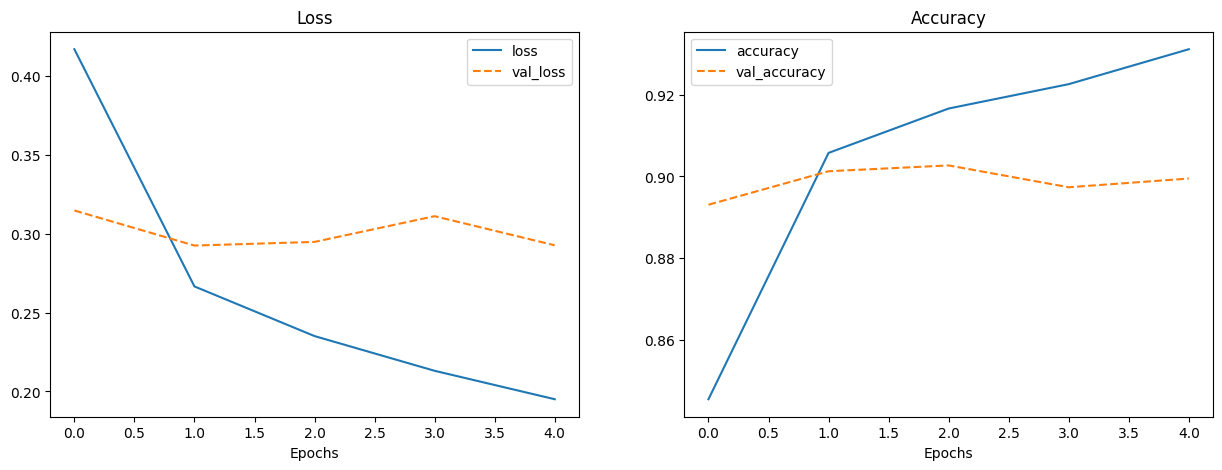

In [49]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')

training_plot(['loss', 'accuracy'], history_mobilenet)


### Results of MobileNet2

- Nearly 90% accuracy with the help of pre_trained model (I am using MobileNetV2 for this assessment.)
- Overfitting becomes apparent after epoch 2
- Val-loss also stays at the smae level as epoch 2 and after that.
- Overall, this model has the highest performance on accuracy.

## Task 3.3 Comparative evaluation (2 marks)
Compare the evaluation results of the best systems from tasks 3.1 and 3.2 and answer the following questions.

Display the confusion matrix generated by the best system on the test set. For this you can use, for example, TensorFlow's confusion_matrix.

Identify the most commont type of classification error reported by the confusion matrix, and display 5 images from the test set that have this classification error.

Note that image_dataset_from_directory shuffles the samples each time you complete an epoch. You need to figure out how to retrieve the data, labels, and generate predictions, without saving the entire data in memory.

https://www.kaggle.com/code/mehrdadsadeghi/fashionmnist-cnn-with-tensorflow-confusionmatrix
